# Practical exercise 3

*authors: Asan Agibetov, Georg Dorffner*

Our final practical exercise will feature a medical application, in particular, you will leverage the knowledge you have acquired in the previous exercises to build a CNN to classify MR (magnetic resonance) images of hearts. Towards the end of this exercise you will compare your model with a classifier based on the "Transfer Learning" technique, i.e., we will use a CNN pre-trained on big amounts of natural images and finetune it to our medical images.

Transfer learning is a very successful technique, we encourage you to read more about it in [these notes (Stanford course on CNNs)](http://cs231n.github.io/transfer-learning/).

> In practice, very few people train an entire Convolutional Network from   scratch (with random initialization), because it is relatively rare to    have a dataset of sufficient size. Instead, it is common to pretrain a    ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2        million images with 1000 categories), and then use the ConvNet either as  an initialization or a fixed feature extractor for the task of interest

**As in the handwritten digit recognition exercise**

**Due to the size and computational resource limitation imposed by Microsfot Azure Cloud platform for the free accounts, we will only use a fraction of available images both during training and testing. If you are preparing these exercises on your local machine, and have enough computational resources (any modern i5/i7 Intel CPU (or equivalent) machine), you could (and maybe you should) use the full dataset (contact your instructors to get the instructions for the full dataset).**

**Also, due to limited size of training samples transfer learning will most probably not perform better than a plain CNN trained from scratch, however, this exercise will give you the necessary experience to apply *transfer learning* to full datasets**

## Package imports and global settings

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import random
import itertools as it

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Hyper parameters

In [3]:
# Hyper parameters
num_epochs = 10
batch_size = 10
learning_rate = 0.001

## Data preparation

In this exercise we provide data loaders for both training and testing phases. These data loaders prepare mini-batches of heart images, publicly available at the [Sunnybrook Cardiac Atlas project website](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). These images were used in the 2009 Cardiac MR Left Ventricle Segmentation Challenge held by the MICCAI (major conference in medical imaging) workshop 2009. As part of our exercise you will use these data to build an image classifier for four categories: healthy, hypertrophy, heart failure with infarction and heart failure without infarction.

In [4]:
train_dset = torch.load("./data/train.limited.pt")
test_dset = torch.load("./data/test.limited.pt")

As in the previous exercise, make sure that the data subsampling produces *balanced* classes (roughly equal number of samples for all categories).

In [5]:
from collections import Counter

tr_labels = [y for x, y in train_dset]
te_labels = [y for x, y in test_dset]
print(Counter(tr_labels))
print(Counter(te_labels))

Counter({0: 44, 2: 43, 3: 39, 1: 24})
Counter({0: 23, 2: 18, 3: 11, 1: 8})


**Note that each image is represented as three matrices with dimensions** $224 \times 224$. Although all of our images are *grayscale*, we need to keep the data in this format (three channels of pixel intensities) to use the pretrained network.

torch.Size([3, 224, 224])


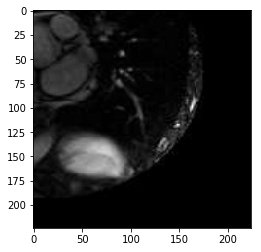

In [6]:
img, label = train_dset[0]
print(img.shape)
plt.set_cmap(plt.get_cmap("gray"))
plt.imshow(img[0].numpy(), interpolation="nearest")

torch.Size([3, 224, 224])


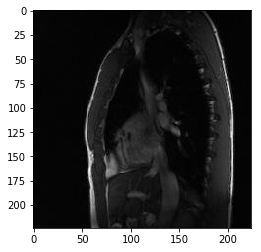

In [7]:
img, label = test_dset[0]
print(img.shape)
plt.set_cmap(plt.get_cmap("gray"))
plt.imshow(img[0].numpy(), interpolation="nearest")

In [8]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Exercise 3.1 CNN from scratch

Use your knowledge to build CNNs and adapt them to our medical images. In particular you have to pay attention to the following:

* as opposed to 1-channel images of digits, we have 3-channel images here. Your convolutional layer will have to account to that!
* digit images had $28 \times 28$ dimensions, the images of hearts have the dimensions of $224 \times 224$.

Below we provide a *direct* adaptation of a 2-layer CNN to our medical dataset. Compare it to the model trained with "transfer learning" (plot loss error, report time it takes to train, and the mean accuracy score). Try to train *deeper* convolutional networks with more layers, by gradually convolving and downsampling the original and produced (filter) images, and compare these architectures to the pretrained model. 

In [10]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.Conv2d(3, 16, kernel_size=4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # self.fc = nn.Linear(7*7*32, 10) 
        self.fc = nn.Linear(53*53*32, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 
    
# cnn = CNN()

Epoch [1/10], Iter [5/15] Loss: 6.4116
Epoch [1/10], Iter [10/15] Loss: 5.4291
Epoch [1/10], Iter [15/15] Loss: 8.0590
Epoch [2/10], Iter [5/15] Loss: 2.5304
Epoch [2/10], Iter [10/15] Loss: 5.5768
Epoch [2/10], Iter [15/15] Loss: 3.0113
Epoch [3/10], Iter [5/15] Loss: 2.6899
Epoch [3/10], Iter [10/15] Loss: 2.2183
Epoch [3/10], Iter [15/15] Loss: 0.7352
Epoch [4/10], Iter [5/15] Loss: 0.7671
Epoch [4/10], Iter [10/15] Loss: 1.7504
Epoch [4/10], Iter [15/15] Loss: 1.3708
Epoch [5/10], Iter [5/15] Loss: 0.3124
Epoch [5/10], Iter [10/15] Loss: 1.0942
Epoch [5/10], Iter [15/15] Loss: 0.1320
Epoch [6/10], Iter [5/15] Loss: 0.0125
Epoch [6/10], Iter [10/15] Loss: 0.9739
Epoch [6/10], Iter [15/15] Loss: 0.2007
Epoch [7/10], Iter [5/15] Loss: 0.2785
Epoch [7/10], Iter [10/15] Loss: 0.5195
Epoch [7/10], Iter [15/15] Loss: 0.0761
Epoch [8/10], Iter [5/15] Loss: 0.0045
Epoch [8/10], Iter [10/15] Loss: 0.1728
Epoch [8/10], Iter [15/15] Loss: 0.0032
Epoch [9/10], Iter [5/15] Loss: 0.2497
Epoch [9/

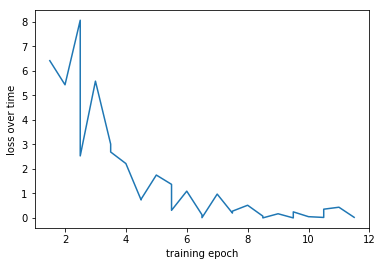

In [11]:
# Loss and Optimizer
# made this into function for easier calling in rest of notebook:
import time 
def optimiser(test_net):
    start_time = time.time()
    epoch_data = []
    loss_data = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(test_net.parameters(), lr=learning_rate)

    # Train the Model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = test_net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                # for plotting, append epoch and loss data to timeseries:
                epoch_data.append(epoch+1+(i+1)/10.0) # epochs as 1, 1.5, 2.0 etc
                loss_data.append(loss.data[0])
                loss.data[0]
                print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                       %(epoch+1, num_epochs, i+1, len(train_dset)//batch_size, loss.data[0]))

    print("time elapsed: {}".format(time.time()-start_time))
    plt.plot(epoch_data, loss_data)
    plt.ylabel('loss over time')
    plt.xlabel('training epoch')
    plt.show()
    
cnn = CNN()                
optimiser(cnn)

In [12]:
# Test the Model
def tester(test_net):
    test_net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images)
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dset), 100 * correct / total))

tester(cnn)

Test Accuracy of the model on the 60 test images: 25 %


**Comments:** <br /> 
The baseline CNN shows a classification accuracy of 25%, which is not very high but at least should let score increases be seen better - a change from 25 to 40%, for instance, is more "dramatic" and noticeable then incremental changes from 97% to 99% on the MNIST dataset...

For the remainder of the exercise, I tested the following deeper CNNs:

1. A 3-layer convnet ("DeeperCNN")
2. A 4-layer convnet ("EvenDeeperCNN") 
3. A 4-layer convnet with additional 3 fully connected, batch-normalized classification layers before the output ("DeeperAndFullerCNN") 


In [13]:
class DeeperCNN(CNN): #inherit from CNN, add 1 layer
    def __init__(self):
        # inherit 
        super(DeeperCNN, self).__init__()
        # add a layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=6),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # redefine the fc layer
        self.fc = nn.Linear(24*24*64, 10)
        
    def forward(self, x): 
        # add 3rd layer definition
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 


Epoch [1/10], Iter [5/15] Loss: 4.0026
Epoch [1/10], Iter [10/15] Loss: 4.4602
Epoch [1/10], Iter [15/15] Loss: 3.3749
Epoch [2/10], Iter [5/15] Loss: 2.9780
Epoch [2/10], Iter [10/15] Loss: 1.1789
Epoch [2/10], Iter [15/15] Loss: 4.2004
Epoch [3/10], Iter [5/15] Loss: 0.9890
Epoch [3/10], Iter [10/15] Loss: 2.4362
Epoch [3/10], Iter [15/15] Loss: 1.0415
Epoch [4/10], Iter [5/15] Loss: 2.0200
Epoch [4/10], Iter [10/15] Loss: 1.5682
Epoch [4/10], Iter [15/15] Loss: 0.4370
Epoch [5/10], Iter [5/15] Loss: 0.7261
Epoch [5/10], Iter [10/15] Loss: 1.2424
Epoch [5/10], Iter [15/15] Loss: 0.5836
Epoch [6/10], Iter [5/15] Loss: 0.2923
Epoch [6/10], Iter [10/15] Loss: 0.3784
Epoch [6/10], Iter [15/15] Loss: 0.1393
Epoch [7/10], Iter [5/15] Loss: 0.1373
Epoch [7/10], Iter [10/15] Loss: 0.3845
Epoch [7/10], Iter [15/15] Loss: 0.3962
Epoch [8/10], Iter [5/15] Loss: 0.0846
Epoch [8/10], Iter [10/15] Loss: 0.2039
Epoch [8/10], Iter [15/15] Loss: 0.0537
Epoch [9/10], Iter [5/15] Loss: 0.1699
Epoch [9/

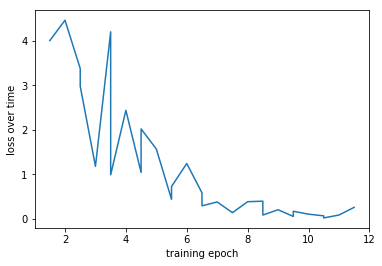

Test Accuracy of the model on the 60 test images: 35 %


In [14]:
deeper_cnn = DeeperCNN()
optimiser(deeper_cnn)
tester(deeper_cnn)

**Comments:** <br /> 



In [15]:
class EvenDeeperCNN(DeeperCNN): #inherit from DeeperCNN, add another layer
    def __init__(self):
        # inherit 
        super(EvenDeeperCNN, self).__init__()
        # add a layer
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # redefine the fc layer
        self.fc = nn.Linear(10*10*128, 10)
        
    def forward(self, x): 
        # add 3rd layer definition
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

Epoch [1/10], Iter [5/15] Loss: 1.6367
Epoch [1/10], Iter [10/15] Loss: 2.4354
Epoch [1/10], Iter [15/15] Loss: 2.3491
Epoch [2/10], Iter [5/15] Loss: 0.9453
Epoch [2/10], Iter [10/15] Loss: 1.5500
Epoch [2/10], Iter [15/15] Loss: 2.1028
Epoch [3/10], Iter [5/15] Loss: 1.1172
Epoch [3/10], Iter [10/15] Loss: 1.1078
Epoch [3/10], Iter [15/15] Loss: 1.1265
Epoch [4/10], Iter [5/15] Loss: 1.5032
Epoch [4/10], Iter [10/15] Loss: 0.9513
Epoch [4/10], Iter [15/15] Loss: 0.8920
Epoch [5/10], Iter [5/15] Loss: 0.9200
Epoch [5/10], Iter [10/15] Loss: 0.8381
Epoch [5/10], Iter [15/15] Loss: 0.6873
Epoch [6/10], Iter [5/15] Loss: 1.0667
Epoch [6/10], Iter [10/15] Loss: 0.4783
Epoch [6/10], Iter [15/15] Loss: 1.0442
Epoch [7/10], Iter [5/15] Loss: 0.5126
Epoch [7/10], Iter [10/15] Loss: 0.7448
Epoch [7/10], Iter [15/15] Loss: 0.5971
Epoch [8/10], Iter [5/15] Loss: 0.4911
Epoch [8/10], Iter [10/15] Loss: 1.0232
Epoch [8/10], Iter [15/15] Loss: 0.8899
Epoch [9/10], Iter [5/15] Loss: 0.1644
Epoch [9/

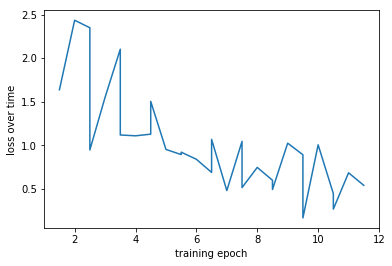

Test Accuracy of the model on the 60 test images: 35 %


In [16]:
even_deeper_cnn = EvenDeeperCNN()
optimiser(even_deeper_cnn)
tester(even_deeper_cnn)

In [24]:
class DeeperAndFullerCNN(EvenDeeperCNN): 
    def __init__(self):
        # inherit the 4-layer CNN
        super(DeeperAndFullerCNN, self).__init__()
        # expand the fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(10*10*128, 10*128),
            nn.BatchNorm1d(10*128),
            nn.ReLU(),
            nn.Linear(10*128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10))

Epoch [1/10], Iter [5/15] Loss: 2.4092
Epoch [1/10], Iter [10/15] Loss: 2.0691
Epoch [1/10], Iter [15/15] Loss: 2.1678
Epoch [2/10], Iter [5/15] Loss: 1.5901
Epoch [2/10], Iter [10/15] Loss: 1.7759
Epoch [2/10], Iter [15/15] Loss: 1.7574
Epoch [3/10], Iter [5/15] Loss: 1.5989
Epoch [3/10], Iter [10/15] Loss: 1.4514
Epoch [3/10], Iter [15/15] Loss: 1.5956
Epoch [4/10], Iter [5/15] Loss: 1.0784
Epoch [4/10], Iter [10/15] Loss: 1.3752
Epoch [4/10], Iter [15/15] Loss: 1.2016
Epoch [5/10], Iter [5/15] Loss: 1.2368
Epoch [5/10], Iter [10/15] Loss: 1.4359
Epoch [5/10], Iter [15/15] Loss: 0.8998
Epoch [6/10], Iter [5/15] Loss: 1.1243
Epoch [6/10], Iter [10/15] Loss: 0.7894
Epoch [6/10], Iter [15/15] Loss: 1.0716
Epoch [7/10], Iter [5/15] Loss: 0.6022
Epoch [7/10], Iter [10/15] Loss: 0.7334
Epoch [7/10], Iter [15/15] Loss: 1.0873
Epoch [8/10], Iter [5/15] Loss: 0.9364
Epoch [8/10], Iter [15/15] Loss: 0.9452
Epoch [9/10], Iter [5/15] Loss: 0.7080
Epoch [9/10], Iter [10/15] Loss: 0.6439
Epoch [9/

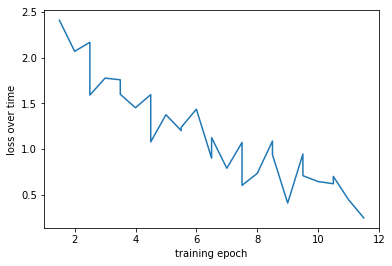

Test Accuracy of the model on the 60 test images: 53 %


In [25]:
deeper_fuller_cnn = DeeperAndFullerCNN()
optimiser(deeper_fuller_cnn)
tester(deeper_fuller_cnn)

**Comments:** <br /> 
For this more complicated classification task, increasing depth and complexity of the convnets seems to pay off more. The 3-layer and 4-layer convnets without additional FC layers increase classification score from 25% to 35%, and the extra 3 linear layers of the final CNN pushes this to 53%. <br />  
 At this rate, it may almost be competitive with the Transfer Learning model trained below, at least under the constraints of the low training time allotted on an Azure instance. (Due to a persistent "out-of-memory" runtime Error on Azure, I could not repeat the final testing of the ResNet-18 model, but from memory it was in the 60% region, i.e. in the same order of magnitude, when trained for 10 epochs.)<br /> 
The training loss curve is noticeably more uneven than during the MNIST number task - it would be interesting to see whether this apparent "instability" would continue when using longer training times (beyond 10 epochs, on a more powerful GPU.) <br /> 

## Transfer learning

Finally, we are going to use some transfer learning. `pytorch` conveniently provides pre-trained networks in its *model zoo*. Here we will use the [ResNet-18](https://arxiv.org/abs/1512.03385) model trained on [ImageNet](www.image-net.org) dataset (over ten million of annotated images available on the Web). As you will see, the ResNet-18 model allows efficient training of very *deep* Convolutional Neural Networks (original paper mentions up to 152 layers, we will *only* use 18 layers).

In the following we *fine-tune* the ResNet-18 to our problem, i.e., we load a pretrained model and reset the final fully connected layer (classification pipeline). Original ResNet-18 used a fully connected layer to classify images belonging to thousands of categories, in our case we only have 4 categories. The rest of training proceeds as usual.

In [9]:
RESNET18 = models.resnet18(pretrained=True)
RESNET18.fc = nn.Linear(RESNET18.fc.in_features, 4)

In [10]:
RESNET18

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [11]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = RESNET18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train_dset)//batch_size, loss.data[0]))

Epoch [1/10], Iter [5/15] Loss: 3.0705
Epoch [1/10], Iter [10/15] Loss: 1.0113
Epoch [1/10], Iter [15/15] Loss: 1.6576
Epoch [2/10], Iter [5/15] Loss: 1.4903
Epoch [2/10], Iter [10/15] Loss: 1.1927
Epoch [2/10], Iter [15/15] Loss: 1.2316
Epoch [3/10], Iter [5/15] Loss: 1.0176
Epoch [3/10], Iter [10/15] Loss: 1.1703
Epoch [3/10], Iter [15/15] Loss: 1.2751
Epoch [4/10], Iter [5/15] Loss: 1.0965
Epoch [4/10], Iter [10/15] Loss: 1.0633
Epoch [4/10], Iter [15/15] Loss: 0.8523
Epoch [5/10], Iter [5/15] Loss: 0.5903
Epoch [5/10], Iter [10/15] Loss: 0.5682
Epoch [5/10], Iter [15/15] Loss: 0.5583
Epoch [6/10], Iter [5/15] Loss: 1.1179
Epoch [6/10], Iter [10/15] Loss: 0.5546
Epoch [6/10], Iter [15/15] Loss: 1.1035
Epoch [7/10], Iter [5/15] Loss: 0.9290
Epoch [7/10], Iter [10/15] Loss: 0.5070
Epoch [7/10], Iter [15/15] Loss: 0.5145
Epoch [8/10], Iter [5/15] Loss: 1.2672
Epoch [8/10], Iter [10/15] Loss: 0.3984
Epoch [8/10], Iter [15/15] Loss: 2.0254
Epoch [9/10], Iter [5/15] Loss: 0.7348
Epoch [9/

In [13]:
# Test the Model
RESNET18.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = RESNET18(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dset), 100 * correct / total))

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1503963423183/work/torch/lib/TH/THGeneral.c:270

**Comment:** The ResNet18 part only worked once, at the begin of the exercise (see recurring error message above) - however, enough to demonstrate the principle and to show an achievable higher baseline score that is more realistic than the mere 25% given by a 2-layer from-scratch convnet.